In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [78]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import SystemMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.prompts import ChatPromptTemplate

# Corrected planner_prompt
planner_prompt = ChatPromptTemplate.from_template(
    """
    Using user's input to make a recipe containing recipe name, ingredients, cook guide.
    {messages}
    """
)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

planner = planner_prompt | llm_with_tools

# Corrected structure_prompt
structure_prompt = ChatPromptTemplate.from_template(
    """
    Structure the output data in JSON format, containing:
    - recipe_name
    - instructions
    - ingredients.
    {messages}
    """
)

structure = structure_prompt | ChatOpenAI(
    model="gpt-3.5-turbo-0125", temperature=0
)


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

def generate_recipe(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def structured_output(state: State):
    return {"messages": [structure.invoke(state["messages"])]}


graph_builder.add_node("recipe", generate_recipe)
graph_builder.add_node("structured", structured_output)

graph_builder.add_edge(START, "recipe")
graph_builder.add_edge("recipe", "structured")
graph_builder.add_edge("structured", END)

In [79]:
graph = graph_builder.compile(checkpointer=memory)

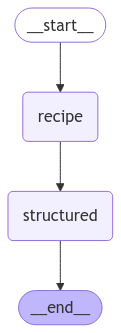

In [80]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [81]:
config = {"configurable": {"thread_id": "1"}}

In [82]:
user_input = "我有牛肉、鹽巴、白麵"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

我有牛肉、鹽巴、白麵
================================== Ai Message ==================================

你可以用牛肉、鹽巴和白麵做一道簡單而美味的料理，比如牛肉炒麵。以下是一個簡單的食譜：

### 牛肉炒麵

#### 材料：
- 牛肉：200克，切片
- 白麵：200克
- 鹽巴：適量
- 蔥花或洋蔥：可選
- 大蒜：2瓣，切碎
- 生抽：1湯匙（可選）
- 老抽：1茶匙（可選）
- 植物油：適量
- 黑胡椒：適量

#### 做法：

1. **準備麵條**：
   - 將白麵放入滾水中煮熟，根據包裝指示的時間煮麵，然後撈出，用冷水沖洗並瀝乾。

2. **醃製牛肉**：
   - 在牛肉片中加入少許鹽、黑胡椒和一半的大蒜，拌勻，醃製10分鐘。

3. **炒牛肉**：
   - 在鍋中加熱適量的植物油，加入剩下的大蒜爆香。
   - 加入牛肉片，翻炒至變色，然後盛出備用。

4. **炒麵**：
   - 在同一鍋中，加入少許油，加入煮熟的白麵，翻炒均勻。
   - 如果你有蔥花或洋蔥，可以在此時加入一起炒。

5. **混合與調味**：
   - 將牛肉倒回鍋中，與麵條混合，加入生抽和老抽（如果使用），翻炒均勻。
   - 根據口味調整鹽和黑胡椒。

6. **完成**：
   - 裝盤，撒上蔥花點綴，即可享用。

這道菜既簡單又美味，完美利用了你手中的食材！享受你的美食吧！
================================== Ai Message ==================================

```json
{
    "recipe_name": "牛肉炒麵",
    "instructions": [
        "準備麵條：將白麵放入滾水中煮熟，根據包裝指示的時間煮麵，然後撈出，用冷水沖洗並瀝乾。",
        "醃製牛肉：在牛肉片中加入少許鹽、黑胡椒和一半的大蒜，拌勻，醃製10分鐘。",
        "炒牛肉：在鍋中加熱適量的植物油，加入剩下的大